# Men Also Like Shopping: Reducing Gender Bias Amplification using Corpus-level Constraints

by Jieyu Zhao, Tianlu Wang, Mark Yatskar, Vicente Ordonez, Kai-Wei Chang

Reference: [EMNLP 2017 paper](https://arxiv.org/abs/1707.09457)

## Abstract
Language is increasingly being used to define rich visual recognition problems with
supporting image collections sourced from
the web. Structured prediction models are
used in these tasks to take advantage of
correlations between co-occurring labels
and visual input but risk inadvertently encoding
social biases found in web corpora.
In this work, we study data and models associated
with multilabel object classification
and visual semantic role labeling. We
find that (a) datasets for these tasks contain
significant gender bias and (b) models
trained on these datasets further amplify
existing bias. For example, the activity
cooking is over 33% more likely
to involve females than males in a training
set, and a trained model further amplifies the disparity to 68% at test time. We
propose to inject corpus-level constraints
for calibrating existing structured prediction
models and design an algorithm based
on Lagrangian relaxation for collective inference.
Our method results in almost no
performance loss for the underlying recognition
task but decreases the magnitude of
bias amplification by 47.5% and 40.5% for
multilabel classification and visual semantic
role labeling, respectively.

## 1. Motivation: Let's take a look at the visual semantic role labeling (vSRL) task 

The visual semantic labeling (vSRL) tasks aim at extracting rich semantics
from images and require large quantities of labeled
data, predominantly retrieved from the web. Each image
is paired with a table describing a situation: the verb, cooking, its semantic roles, i.e agent, and
noun values filling that role, i.e. woman. The following figure demonstrate a few examples predicted by a vSRL system.

![Examples from vSRL dataset.](../img/bias_teaser.png)
*Figure 1: Examples from vSRL dataset. All the tables are the predicted results for the corresponding imagess. *


Methods often combine structured prediction and
deep learning to model correlations between labels
and images to make judgments that otherwise
would have weak visual support. For example, in
the first image of Figure 1, it is possible to predict
a spatula by considering that it is a common
tool used for the activity cooking. Yet such
methods run the risk of discovering and exploiting
societal biases present in the underlying web corpora.
Without properly quantifying and reducing
the reliance on such correlations, broad adoption
of these models can have the inadvertent effect of
magnifying stereotypes.

## 2. Visualizing and Quantifying Biases

In this paper, we develop a general framework for quantifying bias and study two concrete tasks, visual semantic role labeling (vSRL) and multilabel object classification (MLC). We use gender bias as a running example and show that both supporting datasets for these tasks are biased with respect to a gender binary. Our analysis reveals that over 50% and 40% of verbs and objects, respectively, exhibit bias toward a gender greater than 2:1. For example, as seen in Figure 1, the cooking activity in imSitu is a heavily biased verb. Furthermore, we show that after training state-of-the-art structured predictors, models amplify the existing bias, by 5.0% for vSRL, and 3.2% in MLC.

Here we show the amplified bias in the model. The x-axis is the training gender ratio, y-axis is the predicted gender ratio. The solid blue line is the result that each verb's gender ratio equals to the trainig ratio. All the dots are the predicted results in the development dataset. A gender ratio closer to 1 means this verb is more biased to male. We can see that in both male and female direction, the bias is amplified -- the predicted gender ratio is even more biased to the corresponding gender. We first provide the result on vSRL task and then show the result for MLC. The helper functions defined in fairCRF_utils.py and inference_debias.py can be found [here](fairCRF_utils.py) (fairCRF_utils) and [here](inference_debias.py) (inference_debias). All the files needed for MLC task are under [data](../data/COCO) folder. While the potential files for vSRL task is too large to put here, you can get the sampled potential files and other files [here](../data/imSitu). If you want to try the whole vSRL dataset, you can get it [here](https://s3.amazonaws.com/MY89_Transfer/webly_crf_output.tar).

In [1]:
import preprocess as mypreprocess
import fairCRF_utils as myutils
import inference_debias as cocoutils

In [2]:
myutils.set_GPU(0)

### 2.1 Bias in  vSRL

start loading potential files
. . . . . . . . . . . 
Finish loading dev potential files


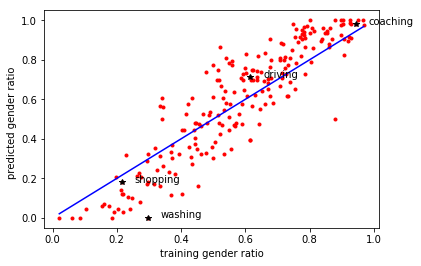

In [3]:
margin = 0.05
vSRL = 1
is_dev = 1
myutils.show_amplified_bias(margin, vSRL, is_dev)

#### imSitu is biased.
In the above figure, along the x-axis, we show the male favoring bias of imSitu verbs. Overall, the dataset is heavily biased toward male agents, with 64.6% of verbs favoring a male agent by an average bias of 0.707 (roughly 3:1 male). Nearly half of verbs are extremely biased in the male or female direction: 46.95% of verbs favor a gender with a bias of at least 0.7. Also it contains several activity labels revealing problematic biases. For example, "shopping" and "washing" are biased toward a female agent. Furthermore, several verbs such as "driving" and "coaching" are heavily biased toward a male agent.
#### Training on imSitu amplifies bias.
Also in this figure, along the y-axis, we show the ratio of male agents (% of total people) in predictions on an unseen development set. The mean bias ampli- fication in the development set is high, 0.050 on average, with 45.75% of verbs exhibiting amplification. Biased verbs tend to have stronger amplification: verbs with training bias over 0.7 in either the male or female direction have a mean amplification of 0.072. Several already problematic biases have gotten much worse. For example, serving, only had a small bias toward females in the training set, 0.402, is now heavily biased toward females, 0.122. 

## 3. Calibration Algorithm
To mitigate the role of bias amplification when training models on biased corpora, we propose a novel constrained inference framework, called RBA, for Reducing Bias Amplification in predictions. Our method introduces corpus-level constraints so that gender indicators co-occur no more often together with elements of the prediction task than in the original training distribution. We combine our calibration constraint with the original structured predictor and use Lagrangian relaxation to reweigh bias creating factors in the original model. The results show that our algorithm can efficiently reduce the amplifed bias while doesn't hurt much to the performance, approximately only 0.2% difference.


### <span style="color:blue"> 3.1 Reducing Bias Amplification (RBA) </span> 
The first goal is to collect the statistics in the training data in order to generate reference gender ratio for each first. Then we can design  corpus-level constrints to ensure the gender ratio for each verb is within the margin of the corresponding reference ratio. In vSRL, we get the constraints for each verb as {verb_id: ((m_c1, f_c1), (m_c2, f_c2), val)}.  (m_c1,f_c1) is for the constraint: $\frac{m}{m+f} \geq tr - \epsilon$ and (m_c2,f_c2) is for the constraint: $\frac{m}{m+f} \leq tr + \epsilon$. Here $tr$ refers to the training gender ratio. For the first one, we get $(tr-\epsilon-1)\cdot m + (tr-\epsilon)\cdot f \leq val$. Here $\epsilon$ is the margin that user can set. In MLC, the constraints have the same format except that each verb should be each object.


We add some constraints to the verbs we considered: in the training time, this verb should have at least #num_gender agents is a man or woman; and in the predictions, m+f > #num_cons_verb. We add these constraints because we want to make sure that this verb is related to gender otherwise it will be difficult to change the gender ratio, for example if this verb only have one "man" agent, it will be impossible to calibrate the gender ratio. As we described in our paper, in the end, we focus on 212 verbs and 66 objects.

<img src="../img/constraints_show.png" width="450">
*Figure 2: Example for vSRL constraints. In the figure, the x-axis is the training gender ratio, the y-axis is the predicted gender ratio. The solid blue line is the reference ratio (predicted gender ratio equals to the training gender ratio). The dashed blue lines are the margins that user can define. Green dots mean these verbs are satisfied with the constraints while the red ones mean the verbs violate the constraints and need to be calibrated.*



#### <span style="color:blue"> Lagrangian for calibrating </span> 
The optimal object is: $L(\lambda, y) = f(y) - \sum_k \lambda_k(\sum_{i,r}c_k\cdot y_{i,r}-val), \forall k, \lambda_k \geq 0$. Here $val = 0$ (we can get from the constraints), $i$ stands for each instance and $r$ stands for each role. 

1) First do the original inference;

2) Using the inference results to update the lambdas: $\lambda_k = \lambda_k - \eta * (-\sum_{i,r}c_k\cdot y_{i,r})$ 

3) Update the coresponding $y_{i,r}$: $y_{i,r} = (s_0 - \lambda_k\cdot c_k)\cdot y_{i,r}$

The **<span style="color:blue">lagrange_with_margins</span>** function takes these parameters: margin, eta, constraints, inference, get_acc, get_update_index, all_man_idx, all_woman_idx, arg_inner_all, vSRL, \*args. 
- **margin** is a float number, which refers to the $\epsilon$ in the constraints above. 
- **eta** is the learning rate for the algorithm.
- **constraints** is a dictionary following the above format. 
- **inference** is your own inference algorithm which will return a top1 result and a dictionary {obj:[#man, #woman]}. If your inference algorithm provides several predictions, top1 just picks the most likely one. The dictionary contains the information of how many times the object is related to **man** and **woman**. In imSitu dataset, the obj refers to the **verb** while in MS-COCO dataset, it means the detected **objection**. 
- **get_acc** is the function to calculate the current accuracy of the prediction. 
- **get_update_index** is the function identifying which lagrangian multipliers need updating.
- **all_man_idx** and **all_woman_idx** are two lists used to update the Lagrangian multipliers. In imSitu they refer to the index in the role_potential_file that this entry refers to a man or woman "agent". In COCO, it refers to the index related to man or woman images. You can define your own idx lists as long as they relates to all man and woman related items respectively. 
- **arg_inner_all** is the potential scores used for inference and calcuating the accuracy. This can be get from the prediction system. The potential scores are 2d-arrays, each entry stands for the potential scores for one instance. Based on different applications, you may need several potential files to get the inference or the accuracy. For example, in vSRL, we need arg_inner_all(related to all the roles), value_frame_inner_all(related to the verbs), label_all(related to the true label), while in MLC we only need arg_inner_all. 
- **vSRL** is a flag to tell the system which task(vSRL/MLC) to run.
- **\*arg** refers to other parameters that you may need to get the inference results or the accuracy.

In [4]:
def lagrange_with_margins(margin, eta, constraints, inference, get_acc, get_update_index, 
                          all_man_idx, all_woman_idx, arg_inner_all, vSRL, *args):
    lambdas = {item:[0,0] for item in constraints}
    arg_inner_tmp = arg_inner_all.copy()
    results = []
    if vSRL == 1:
        inf_arg = (args[0:-1])
        acc_arg = (args[0:2]) + (args[-1],)
    else:
        inf_arg = ""
        acc_arg = (args[0],)
        
    print "Starting Lagrangian part"     
    for epoch in range(100):
        count = 0
        error = {item:[0,0] for item in constraints}

        top1, pred_agents = inference(arg_inner_tmp, *inf_arg) 
        non_zeros = {}
        for k in constraints:
            if k in pred_agents:
                    lambdas[k][0] += eta * constraints[k][0][0] * pred_agents[k][0]
                    lambdas[k][1] += eta * constraints[k][1][0] * pred_agents[k][0]
                    error[k][0] += constraints[k][0][0] * pred_agents[k][0]
                    error[k][1] +=  constraints[k][1][0] * pred_agents[k][0]
                    lambdas[k][0] += eta * constraints[k][0][1] * pred_agents[k][1]
                    lambdas[k][1] += eta * constraints[k][1][1] * pred_agents[k][1]
                    error[k][0] += constraints[k][0][1] *  pred_agents[k][1]
                    error[k][1] +=  constraints[k][1][1] *  pred_agents[k][1]
        
        for k in lambdas:
            for i in range(2):
                if lambdas[k][i] <= 0:
                    lambdas[k][i] = 0

        for k in error:
            for i in range(2):
                if error[k][i] > 0:
                    count += 1

        arg_inner_tmp = arg_inner_all.copy()

        for i in range(len(arg_inner_tmp)):
            for arg_idx in top1[i][1]:
                if arg_idx in all_man_idx:
                    k = get_update_index(top1, i, arg_idx, 1, vSRL)
                    if k in lambdas:  
                        arg_inner_tmp[i][arg_idx] -= lambdas[k][0] * constraints[k][0][0] 
                        arg_inner_tmp[i][arg_idx] -= lambdas[k][1] * constraints[k][1][0]
                if arg_idx in all_woman_idx:
                    k = get_update_index(top1, i, arg_idx, 0, vSRL)
                    if k in lambdas: 
                        arg_inner_tmp[i][arg_idx] -= lambdas[k][0] * constraints[k][0][1] 
                        arg_inner_tmp[i][arg_idx] -= lambdas[k][1] * constraints[k][1][1]

        if epoch % 10 == 0 or epoch == 99:
            print "%s-th epoch, number of times that constrints are not satisfied:"%(epoch), count
            acc1 = get_acc(arg_inner_tmp, *acc_arg)
            print "%s-epoch, acc is: "%(epoch),acc1
            results.append([epoch, count, acc1])
            
        if count == 0:
            break
    myutils.save_iterations(myutils.configs['save_iteration'] + "_margin_" + str(margin), results)
    myutils.save_lambdas(myutils.configs['save_lambda'] + "_margin_" + str(margin), lambdas)
    return arg_inner_tmp, lambdas


### <span style="color:blue"> 3.2 Running example </span>
Here we give an example of running the calibrating function in vSRL and MLC tasks. **vSRL** is used to define which task to run. And you can set your own **margin** and **eta**. **is_dev** defines which dataset (development, test) we want to use. (Remember to change the file path in config.ini. Using the absolute path)



In [5]:
def run(margin, vSRL, is_dev, eta):
    reargs = mypreprocess.preprocess(margin, vSRL, is_dev)
    if vSRL != 1:
        eta = 0.05
        (constraints, all_man_idx, all_woman_idx, arg_inner_all, 
         target, pred_objs_bef, cons_verbs, train_samples) = reargs
        arg_inner_tmp, lambdas = lagrange_with_margins(margin, eta, constraints, 
                                                       cocoutils.inference, cocoutils.accuracy,
                                                       myutils.get_update_index, all_man_idx, 
                                                       all_woman_idx, arg_inner_all, vSRL, target)
        
        mypreprocess.show_results(margin, vSRL, arg_inner_tmp, cons_verbs, 
                                  train_samples, pred_objs_bef)
    else:
        eta = 0.1
        (arg_inner_all, value_frame_all, label_all, len_verb_file, all_man_idx, all_woman_idx, 
         constraints, output_index, id_verb, verb_roles, cons_verbs, num_gender,words_file, 
         training_file, role_potential_file, verb_id) = reargs
        value_frame_tmp = value_frame_all.copy()
        label = label_all.copy()
        arg_inner_tmp, lambdas = lagrange_with_margins(margin, eta, constraints, 
                                                       myutils.inference, myutils.get_acc, 
                                                       myutils.get_update_index,
                                                       all_man_idx, all_woman_idx, arg_inner_all, 
                                                       vSRL, value_frame_tmp, label,output_index, 
                                                       id_verb, verb_roles, len_verb_file)
        
        mypreprocess.show_results(margin, vSRL, cons_verbs, num_gender, words_file, 
                                  training_file, role_potential_file, arg_inner_all, value_frame_all,
                                  label_all, arg_inner_tmp, value_frame_all, output_index, id_verb, 
                                  verb_id, verb_roles)


### 3.2.1 Calibration for vSRL

We run the RBA algorithm on vSRL task. The following three images show the result for RBA algorithm. The first image shows the prediction before adopting RBA. The second one shows the result after RBA.  The x-axis is the training gender ratio, the y-axis is the predicted gender ratio. The solid blue line is the reference ratio. We can see that after RBA, the predicted ratio gets closer to the reference ratio, which means we can efficiently reduce the amplified bias. The third figure demonstrate bias amplification as a function of training bias, with (blue line) and without (red line) RBA. Here y-axis is the mean amplified bias for a fixed window of verbs. We can see that across all initial training biases, RBA is able to reduce the bias amplification.

In [ ]:
margin = 0.05
is_dev = 1
run(margin, 1, is_dev, 0.1)

preprocessing imSitu dataset
start loading potential files
. . . . . . . . . . . 
Finish loading dev potential files
calcuating the accuracy before calibrating
arg-acc cross before calibrating:  0.24067989411756455
generating the constraints
total number of constraints:  424
-------------------
Starting Lagrangian part
0-th epoch, number of times that constrints are not satisfied: 154
